In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
from gaussian_process import *

# fe.PETScOptions.set("snes_linesearch_monitor", "")
fe.PETScOptions.set("snes_linesearch_type", "bt")

In [2]:
# Define the necessary parameters
N_SIM = 3    # number of simulations
N_F = 5      # number of frequencies
mu = 0.0   
sigma = 5.0
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 2
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = fe.Constant(0.01)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)


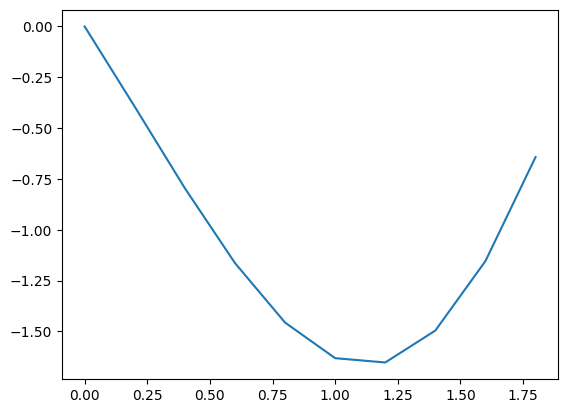

In [3]:
# Generate the gaussian BCs
np.random.seed(20)


def generate_gauss():
    
    """The function returns the Gaussian processes A(t) and P(t). 
         See Regazzoni et al."""
    
    mu = 0.0
    tau = 5.0
    sigma = 5.0
  
    # Covariance kernel function
    def covariance_kernel(t1, t2):
        return sigma**2 * np.exp(-((t1 - t2)**2) / (2 * tau**2))

    # Generate samples of A(t) and P(t) using the covariance kernel
    mean = mu*np.ones(N_TIME_STEPS)
    covariance_matrix = np.fromfunction(np.vectorize(lambda i, j: covariance_kernel(time_vector[i], time_vector[j])), (N_TIME_STEPS, N_TIME_STEPS), dtype=int)
    A_t = np.random.multivariate_normal(mean, covariance_matrix)
    #P_t = np.random.multivariate_normal(mean, covariance_matrix)

    return A_t 

A_t = generate_gauss()
#S_t = np.sin(time_vector/10*np.pi)
u_t_matrix = np.zeros((N_SIM, N_TIME_STEPS))


for i in range(N_SIM):
    A_t = generate_gauss()
    u_t_matrix[i,:] = A_t*np.sin(time_vector/TOTAL_TIME*np.pi)
    
# One row for each simulation, and along the row we have u_t(t_j)
np.save('u_t_matrix.npy',u_t_matrix)

plt.plot(time_vector, u_t_matrix[0,:] )  # check

def eval_u_t(t, indx_sim):
    u_t = u_t_matrix[indx_sim, :].T
    return u_t[np.where(np.abs(time_vector - t) < 1e-3)[0][0]]




In [4]:
# Create XDMF files (one for all the simulations) -> current focus only on velocity
xdmffile_u = fe.XDMFFile('lid_cavity_u_nl_nc.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_p_nl_nc.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True

In [5]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, indx_sim, **kwargs):
        super().__init__(**kwargs)
        self.t = t
        self.sim = indx_sim  # the current simulation
    def eval(self, value, x):
        value[0] = eval_u_t(self.t, self.sim)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [6]:
class BottomVertex(fe.SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0]) < fe.DOLFIN_EPS and abs(x[1]) < fe.DOLFIN_EPS)

In [7]:
def solve_problem(indx_sim):

    
    # mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS, "crossed")
    domain = Rectangle(fe.Point(0., 0.), fe.Point(1., 1.))
    mesh = generate_mesh(domain, N_POINTS_P_AXIS)
   
    # Taylor-Hood Elements. 
    element_v = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    element_p = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = fe.FunctionSpace(mesh, fe.MixedElement(element_v, element_p))
    V = fe.FunctionSpace(mesh, element_v)
    Q = fe.FunctionSpace(mesh, element_p)

    # Define trial functions
    vq = fe.TestFunction(W)
    delta_up = fe.TrialFunction(W)
    (v, q) = fe.split(vq)

    up = fe.Function(W)
    (u, p) = fe.split(up)

    up_prev = fe.Function(W)
    (u_prev, _) = fe.split(up_prev)

    # Define boundary conditions
    g = u_t_Expression(0.0, indx_sim) 
    noslip = fe.DirichletBC(W.sub(0), (0, 0), "x[0] < DOLFIN_EPS || x[0] > 1.0 - DOLFIN_EPS || x[1] < DOLFIN_EPS")
    lid = fe.DirichletBC(W.sub(0), g, "x[1] > 1.0 - DOLFIN_EPS")
    pref = fe.DirichletBC(W.sub(1), 0, "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

    bc = [noslip, lid, pref]

    # Stabilization if needed
    # h = fe.CellDiameter(mesh)
    # alpha_u = fe.Constant(1.)
    # delta_u = alpha_u*(h**2)
    # alpha_p = fe.Constant(1.)
    # delta_p = alpha_p*(h**2)
    # rho = fe.Constant(0.)
    # rho =   0 -> SUPG (Streamline updwind Petrov Galerkin)
    # rho =   1 -> GALS (Galerkin least squares)
    # rho = - 1 -> Douglas-Wang

    # Tentative velocity step
    F = fe.inner(u, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        - fe.inner(u_prev, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        + fe.inner(fe.grad(u) * u, v) * fe.dx \
        + KINEMATIC_VISCOSITY * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx \
        - fe.div(v) * p * fe.dx \
        - q * fe.div(u) * fe.dx 
        # + fe.inner(- KINEMATIC_VISCOSITY*fe.div(fe.grad(u)) + fe.grad(p),
        #            -  rho*fe.delta_u*KINEMATIC_VISCOSITY*fe.div(fe.grad(v)) + delta_p*fe.grad(q))*fe.dx  # Stabilization term 

    J = fe.derivative(F, up, delta_up)

    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "mumps",
                                            "maximum_iterations": 20,
                                            "report": False,
                                            "error_on_nonconvergence": True}}

    (u, p) = up.split()
    u.rename("u", "")
    p.rename("p","")
    xdmffile_u.write(u, indx_sim*TOTAL_TIME)
    xdmffile_p.write(p, indx_sim*TOTAL_TIME)
    
    for i in tqdm(range(1, N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = i*TIME_STEP_LENGTH
        g.t = t

        # KINEMATIC_VISCOSITY.assign(1.)
        problem = fe.NonlinearVariationalProblem(F, up, bc, J)
        solver  = fe.NonlinearVariationalSolver(problem)
        solver.parameters.update(snes_solver_parameters)
        solver.solve()

        # Store the solution in up_prev
        fe.assign(up_prev, up)

        # Save
        (u, p) = up.split()
        u.rename("u", "")
        p.rename("p","")
        xdmffile_u.write(u, t+indx_sim*TOTAL_TIME)
        xdmffile_p.write(p, t+indx_sim*TOTAL_TIME)
        

In [8]:
def main():
    for i in range(N_SIM):
        solve_problem(i) 

In [9]:
if __name__ == "__main__":
    main()

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:07<01:00,  7.53s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:15<00:52,  7.50s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:22<00:45,  7.61s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:30<00:38,  7.67s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:38<00:30,  7.74s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:46<00:23,  7.83s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:54<00:15,  7.92s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:02<00:08,  8.06s/it]

Solving nonlinear variational problem.


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:07,  8.40s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:16<00:58,  8.35s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:24<00:49,  8.31s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:33<00:41,  8.32s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:41<00:33,  8.26s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:49<00:24,  8.20s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:57<00:16,  8.27s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:05<00:08,  8.17s/it]

Solving nonlinear variational problem.


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:07<01:03,  7.98s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:18<01:04,  9.23s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:28<00:57,  9.65s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:36<00:45,  9.01s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:46<00:37,  9.45s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:54<00:26,  8.94s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:02<00:17,  8.60s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:10<00:08,  8.40s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:18<00:00,  8.71s/it]
